<a href="https://colab.research.google.com/github/garnieroeliari/weather/blob/main/predict_dina_weather_multiclass_image_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather prediction - Multiclass Image Classification
##**Load previously saved model and make prediction**

By Dina Garnier-Oeliarisoa

The weather classification model was trained from [here](https://colab.research.google.com/drive/1umOz8BWjKOVQRhAElk8cjTQZ0PDMArfS?usp=sharing) 

##**Import libraries**


In [1]:
# Libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class WeatherClassifier(nn.Module):
    def __init__(self):
        super(WeatherClassifier, self).__init__()
        
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=75, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
    
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, dropout, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block        

In [4]:
# LOAD THE ENTIRE MODEL
model_weather = torch.load('/content/drive/MyDrive/Colab Notebooks/colab_image_processing/output/all_classif_weather.pt')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "/content/drive/MyDrive/data_image_side_project/weather/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => /content/drive/MyDrive/data_image_side_project/weather/


In [6]:
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

In [7]:
weather_dataset = datasets.ImageFolder(root = root_dir + "train",
                                   transform = image_transforms["train"]
                                  )

In [8]:
weather_dataset.class_to_idx
idx2class = {v: k for k, v in weather_dataset.class_to_idx.items()}
#print (idx2class)

In [12]:
from PIL import Image
import os
import os.path
import sys
import requests
import matplotlib.pyplot as plt
import numpy as np

def pil_loader(path):    
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def makePrediction(model, url):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = image_transforms["test"]

    test_image = Image.open(requests.get(url, stream=True).raw)
    #test_image= pil_loader(requests.get(url, stream=True).raw)

    plt.imshow(test_image)

    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.unsqueeze(0)       
    test_image_tensor = test_image_tensor.view(3, 300, 300).to(device)
    
    with torch.no_grad():
      model.eval()
      test_image_tensor = test_image_tensor.unsqueeze(0)        
      out = model(test_image_tensor)        
      sm=torch.nn.Softmax(dim=1)
      proba=sm(out)        
      topk, topclass = proba.topk(1, dim=1) 
              
      #*******begin following code if NO GPU*****
      #print (idx2class)
      #print("predicted class : "+str(topclass))
      #print ("probability : "+str(topk))
      #*******end following code if NO GPU*******

      #******begin following code if there is a GPU*******
      numpy_topclass=topclass.detach().cpu().numpy()        
      pred_proba=numpy_topclass[0][0][0][0]
      print("class : "+idx2class[pred_proba])       
      numpy_topk=topk.detach().cpu().numpy()        
      pred_proba=numpy_topk[0][0][0][0]
      print("probability : "+str(pred_proba))
      #*****end following code if there is a GPU***** 
      #print(f"Prediction {i+1} : {idx2class[topclass.cpu().numpy()[0][i]]}, Score: {topk.cpu().numpy()[0][i] * 100}%")

In [13]:
def makePrediction2(model, image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = image_transforms["test"]

    #test_image = Image.open(image)
    test_image= pil_loader(image)

    plt.imshow(test_image)

    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.unsqueeze(0)       
    test_image_tensor = test_image_tensor.view(3, 300, 300).to(device)
    
    with torch.no_grad():
      model.eval()
      test_image_tensor = test_image_tensor.unsqueeze(0)        
      out = model(test_image_tensor)        
      sm=torch.nn.Softmax(dim=1)
      proba=sm(out)        
      topk, topclass = proba.topk(1, dim=1) 
              
      #*******begin following code if NO GPU*****
      #print (idx2class)
      #print("predicted class : "+str(topclass))
      #print ("probability : "+str(topk))
      #*******end following code if NO GPU*******

      #******begin following code if there is a GPU*******
      numpy_topclass=topclass.detach().cpu().numpy()        
      pred_proba=numpy_topclass[0][0][0][0]
      print("class : "+idx2class[pred_proba])       
      numpy_topk=topk.detach().cpu().numpy()        
      pred_proba=numpy_topk[0][0][0][0]
      print("probability : "+str(pred_proba))
      #*****end following code if there is a GPU***** 
      #print(f"Prediction {i+1} : {idx2class[topclass.cpu().numpy()[0][i]]}, Score: {topk.cpu().numpy()[0][i] * 100}%")

class : cloudy
probability : 0.54376376


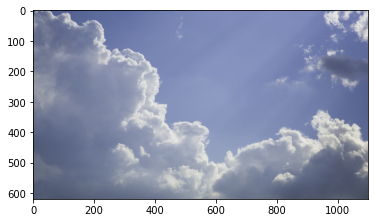

In [14]:
makePrediction(model_weather, 'https://images2.minutemediacdn.com/image/upload/c_crop,h_1193,w_2121,x_0,y_221/f_auto,q_auto,w_1100/v1555155296/shape/mentalfloss/iStock-104472907.jpg')

class : sunrise
probability : 1.0


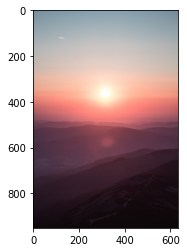

In [15]:
makePrediction(model_weather, 'https://images.squarespace-cdn.com/content/v1/5452d441e4b0c188b51fef1a/1573763056251-4NAPLOTDWOZEIGIJSJ67/ke17ZwdGBToddI8pDm48kBW1iObNR7fZLyl9WCSsLMpZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpyALuDnYTa8vwgJPjQXK6S5xrlUIF5t2q0OHXOUZcHC0R5Iu57vTqP3dwqDO6h43Ss/sunrise.jpeg')

class : rain
probability : 0.94718647


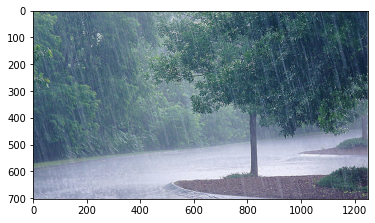

In [16]:
makePrediction2(model_weather, '/content/drive/MyDrive/images_divers/my_image_rain.jpg')

class : shine
probability : 0.7819304


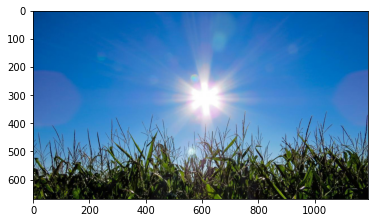

In [17]:
makePrediction(model_weather, 'https://www.lesoir.be/sites/default/files/dpistyles_v2/ena_16_9_extra_big/2019/02/15/node_209664/26165556/public/2019/02/15/B9718594337Z.1_20190215141957_000+GKJD02OCV.1-0.jpg')